In [6]:
import torch
from sklearn.manifold import TSNE
import os
import sys
import datetime

import torch
sys.path.append('../')
from models.model import MNISTmodel, MNISTmodel_plain
from core.train_weight import train_dann
from utils.utils import get_data_loader, get_data_loader_weight, init_model, init_random_seed, get_dataset_root, get_model_root, get_data
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import shutil


In [7]:
data_mode = 0 
run_mode = 0
T = 0.5
class Config(object):
    # params for path
    model_name = "mnist-usps-weight"
    dataset_root = get_dataset_root()
    model_root = get_model_root(model_name, data_mode, run_mode)
    model_root = os.path.join(model_root, datetime.datetime.now().strftime('%m%d_%H%M%S'))
    os.makedirs(model_root, exist_ok=True)
    config = os.path.join(model_root, 'config.txt')
    finetune_flag = False
    data_mode = data_mode 
    run_mode = run_mode
    threshold = (T,T)
    soft = False
    quantile = False
    optimal = True

    # params for datasets and data loader
    batch_size = 500

    # params for source dataset
    src_dataset = "mnist"
    src_model_trained = True
    src_classifier_restore = os.path.join(model_root, src_dataset + '-source-classifier-final.pt')
    class_num_src = 31

    # params for target dataset
    tgt_dataset = "mnistm"
    tgt_model_trained = True
    dann_restore = os.path.join(model_root, src_dataset + '-' + tgt_dataset + '-dann-final.pt')

    # params for pretrain
    num_epochs_src = 100
    log_step_src = 10
    save_step_src = 50
    eval_step_src = 20

    # params for training dann
    gpu_id = '0'

    ## for digit
    num_epochs = 100
    log_step = 20
    save_step = 50
    eval_step = 1

    ## for office
    # num_epochs = 1000
    # log_step = 10  # iters
    # save_step = 500
    # eval_step = 5  # epochs
    lr_adjust_flag = 'simple'
    src_only_flag = False

    manual_seed = 8888
    alpha = 0

    # params for optimizing models
    lr = 5e-4
    momentum = 0
    weight_decay = 0
    
    def __init__(self):
        public_props = (name for name in dir(self) if not name.startswith('_'))
        with open(self.config, 'w') as f:
            for name in public_props:
                f.write(name + ': ' + str(getattr(self, name)) + '\n')

params = Config()

In [61]:
source_weight, target_weight = get_data(params.data_mode)  


In [62]:
model = init_model(net=MNISTmodel(), restore=None)
model.load_state_dict(torch.load('/nobackup/yguo/pytorch-dann/runs/mnist-mnistm/mnist-mnistm-dann-final.pt'))
model.eval()
src_data_loader, num_src_train = get_data_loader_weight(params.src_dataset, params.dataset_root, params.batch_size, train=True, weights = source_weight)
tgt_data_loader, num_tgt_train = get_data_loader_weight(params.tgt_dataset, params.dataset_root, params.batch_size, train=True, weights = target_weight)

No trained model, train from scratch.


In [63]:
"""Train dann."""
device = 0
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from core.test import test
from core.test_weight import test_weight
from utils.utils import save_model
import torch.backends.cudnn as cudnn
import math
cudnn.benchmark = True

"""Train dann."""
####################
# 1. setup network #
####################
# 2. train network #
####################
images_src, class_src, idx_src = next(iter(src_data_loader))
images_tgt, class_target, idx_tgt = next(iter(tgt_data_loader))
# prepare domain label
size_src = len(images_src)
size_tgt = len(images_tgt)
label_src = torch.zeros(size_src).long().to(device)  # source 0
label_tgt = torch.ones(size_tgt).long().to(device)  # target 1

# make images variable
class_src = class_src.to(device)
images_src = images_src.to(device)
images_tgt = images_tgt.to(device)


In [64]:
model.feature

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout2d(p=0.5, inplace=False)
  (7): ReLU(inplace=True)
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

In [65]:
def get_feature(input_data, model): 
    input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
    feature = model.feature(input_data)
    feature = feature.view(-1, 48 * 4 * 4)
    return feature

# Obtain source feature
src_feature = get_feature(images_src, model)

# Obtain target feature 
tgt_feature = get_feature(images_tgt, model)

In [66]:
all_feature = torch.cat([src_feature,tgt_feature],0).detach().cpu().numpy()

In [67]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
dsn_tsne = tsne.fit_transform(all_feature)

In [68]:
all_labels =  torch.cat([class_src.to('cpu'), class_target], 0).detach().cpu().numpy()

In [69]:
all_domains = np.concatenate([np.zeros(500), np.ones(500)])

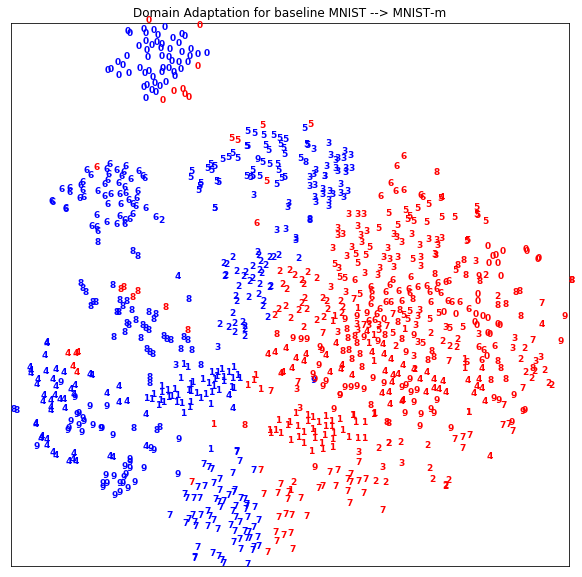

In [70]:
plot_embedding(dsn_tsne, all_labels, all_domains, 'Domain Adaptation for baseline MNIST --> MNIST-m')


In [32]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data

import numpy as np
import hickle as hkl
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import urllib
import os
import tarfile
import skimage
import skimage.io
import skimage.transform

def compose_image(digit, background):
    """Difference-blend a digit and a random patch from a background image."""
    w, h, _ = background.shape
    dw, dh, _ = digit.shape
    x = np.random.randint(0, w - dw)
    y = np.random.randint(0, h - dh)
    bg = background[x:x+dw, y:y+dh]
    return np.abs(bg - digit).astype(np.uint8)

def mnist_to_img(x):
    """Binarize MNIST digit and convert to RGB."""
    x = (x > 0).astype(np.float32)
    d = x.reshape([28, 28, 1]) * 255
    return np.concatenate([d, d, d], 2)

def create_mnistm(X):
    """
    Give an array of MNIST digits, blend random background patches to
    build the MNIST-M dataset as described in
    http://jmlr.org/papers/volume17/15-239/15-239.pdf
    """
    X_ = np.zeros([X.shape[0], 28, 28, 3], np.uint8)
    for i in range(X.shape[0]):
        bg_img = rand.choice(background_data)
        d = mnist_to_img(X[i])
        d = compose_image(d, bg_img)
        X_[i] = d
    return X_

def imshow_grid(images, shape=[2, 8]):
    from mpl_toolkits.axes_grid1 import ImageGrid
    fig = plt.figure()
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)
    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i])
    plt.show()


def difference_loss(private_samples, shared_samples, weight=0.05, name=''):
  private_samples -= tf.reduce_mean(private_samples, 0)
  shared_samples -= tf.reduce_mean(shared_samples, 0)
  private_samples = tf.nn.l2_normalize(private_samples, 1)
  shared_samples = tf.nn.l2_normalize(shared_samples, 1)
  correlation_matrix = tf.matmul( private_samples, shared_samples, transpose_a=True)
  cost = tf.reduce_mean(tf.square(correlation_matrix)) * weight
  cost = tf.where(cost > 0, cost, 0, name='value')
  #tf.summary.scalar('losses/Difference Loss {}'.format(name),cost)
  assert_op = tf.Assert(tf.is_finite(cost), [cost])
  with tf.control_dependencies([assert_op]):
     tf.losses.add_loss(cost)
  return cost


def concat_operation(shared_repr, private_repr):
    return shared_repr + private_repr


class FlipGradientBuilder(object):
    def __init__(self):
        self.num_calls = 0
    def __call__(self, x, l=1.0):
        grad_name = "FlipGradient%d" % self.num_calls
        @ops.RegisterGradient(grad_name)
        def _flip_gradients(op, grad):
            #return [tf.neg(grad) * l]
            return [tf.negative(grad) * l]
        g = tf.get_default_graph()
        with g.gradient_override_map({"Identity": grad_name}):
            y = tf.identity(x)
        self.num_calls += 1
        return y

def shuffle_aligned_list(data):
    """Shuffle arrays in a list by shuffling each array identically."""
    num = data[0].shape[0]
    p = np.random.permutation(num)
    return [d[p] for d in data]


def batch_generator(data, batch_size, shuffle=True):
    """Generate batches of data.
    
    Given a list of array-like objects, generate batches of a given
    size by yielding a list of array-like objects corresponding to the
    same slice of each input.
    """
    if shuffle:
        data = shuffle_aligned_list(data)

    batch_count = 0
    while True:
        if batch_count * batch_size + batch_size >= len(data[0]):
            batch_count = 0

            if shuffle:
                data = shuffle_aligned_list(data)

        start = batch_count * batch_size
        end = start + batch_size
        batch_count += 1
        yield [d[start:end] for d in data]

def weighted_batch_generator(data, batch_size, weight, shuffle = True):
    idx = np.argsort(data[1])
    # Create a sorted dataset according to the label 
    sorted_data = [data[0][idx], data[1][idx]]
    partitioned_data = []
    for i in np.arange(10): 
        partitioned_data.append(data[1][data[0] ==i])
    print("gg")
    
def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        # plot colored number
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.bwr(d[i] / 1.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

def imshow_grid(images, cmap=None,shape=[2, 8],title=''):
    from mpl_toolkits.axes_grid1 import ImageGrid
    fig = plt.figure()
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)
    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i],cmap=cmap)
    fig.suptitle(title,fontsize=16)
    plt.show()

In [14]:
import sys

class Logger(object):
    def __init__(self):
        self.terminal = sys.stdout
        self.log = open("logfile.log", "a")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)  

    def flush(self):
        #this flush method is needed for python 3 compatibility.
        #this handles the flush command by doing nothing.
        #you might want to specify some extra behavior here.
        pass    

sys.stdout = Logger()
print('hello')
